# Task-4 Image Reconstruction using Matrix Factorisation

# Question 4.2

Q2. Consider a case where 900 pixels (30x30) are randomly missing from an image. Reconstruct the image using matrix factorization, plot the reconstructed image, and calculate the RMSE and PSNR metrics. Next, reconstruct the same image with the missing pixels using Random Fourier Features (RFF) and Linear Regression. Compute the RMSE and PSNR for both methods, and compare the results to see which performs better.

### Importing Required Libraries

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn import preprocessing

# remove all warnings
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

try:
    from einops import rearrange
except ImportError:
    %pip install einops
    from einops import rearrange

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

# check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print('Number of GPUs:', torch.cuda.device_count())
# use 8 gpus
torch.cuda.set_device(0)


Using device: cuda
Number of GPUs: 1


In [5]:
# Setting the seed for Python, NumPy, and PyTorch (both CPU and GPU)
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # if using CUDA
    torch.cuda.manual_seed_all(seed)  # for multi-GPU
    torch.backends.cudnn.deterministic = True  # Ensures deterministic behavior
    torch.backends.cudnn.benchmark = False     # Disables the auto-tuner that finds the best algorithm

# Call this function before using any random number generators
set_seed(42)

In [6]:
img = torchvision.io.read_image('./iitgn.jpg')
print(img.shape)

torch.Size([3, 640, 1280])


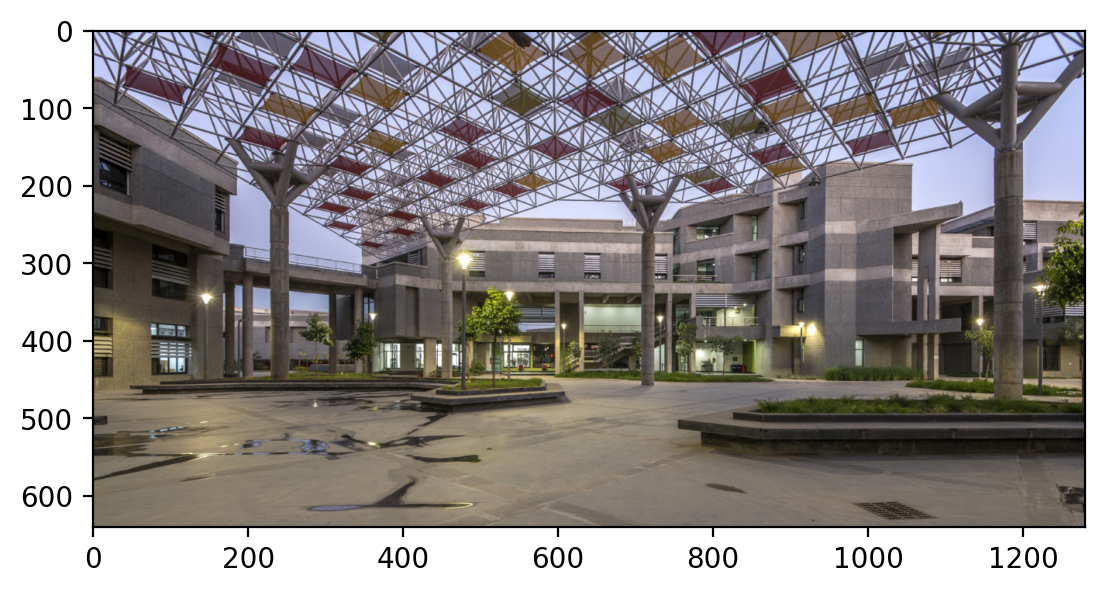

In [7]:
plt.imshow(rearrange(img, 'c h w -> h w c').numpy())

In [8]:
scaler_img = preprocessing.MinMaxScaler().fit(img.reshape(-1, 1))
scaler_img

MinMaxScaler()

In [9]:
img_scaled = scaler_img.transform(img.reshape(-1, 1)).reshape(img.shape)
img_scaled = torch.tensor(img_scaled)

img_scaled = img_scaled.to(device)
print("Shape of the scaled image:", img_scaled.shape)
img_scaled

Shape of the scaled image: torch.Size([3, 640, 1280])


tensor([[[0.7922, 0.7490, 0.7804,  ..., 0.7451, 0.7647, 0.7569],
         [0.7725, 0.7647, 0.7765,  ..., 0.7490, 0.7529, 0.7451],
         [0.7137, 0.7373, 0.8039,  ..., 0.7412, 0.7490, 0.7451],
         ...,
         [0.4784, 0.4784, 0.4784,  ..., 0.4667, 0.4706, 0.4745],
         [0.4784, 0.4784, 0.4784,  ..., 0.4706, 0.4667, 0.4667],
         [0.4784, 0.4745, 0.4745,  ..., 0.4706, 0.4667, 0.4627]],

        [[0.8392, 0.7922, 0.8039,  ..., 0.8157, 0.8314, 0.8235],
         [0.8353, 0.8118, 0.8078,  ..., 0.8235, 0.8196, 0.8078],
         [0.7804, 0.7961, 0.8471,  ..., 0.8235, 0.8118, 0.7922],
         ...,
         [0.4431, 0.4431, 0.4431,  ..., 0.4314, 0.4353, 0.4392],
         [0.4431, 0.4431, 0.4431,  ..., 0.4353, 0.4314, 0.4314],
         [0.4431, 0.4392, 0.4392,  ..., 0.4353, 0.4314, 0.4275]],

        [[1.0000, 0.9686, 0.9373,  ..., 0.9569, 1.0000, 1.0000],
         [1.0000, 1.0000, 0.9608,  ..., 0.9882, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 0.

torch.Size([3, 300, 300])


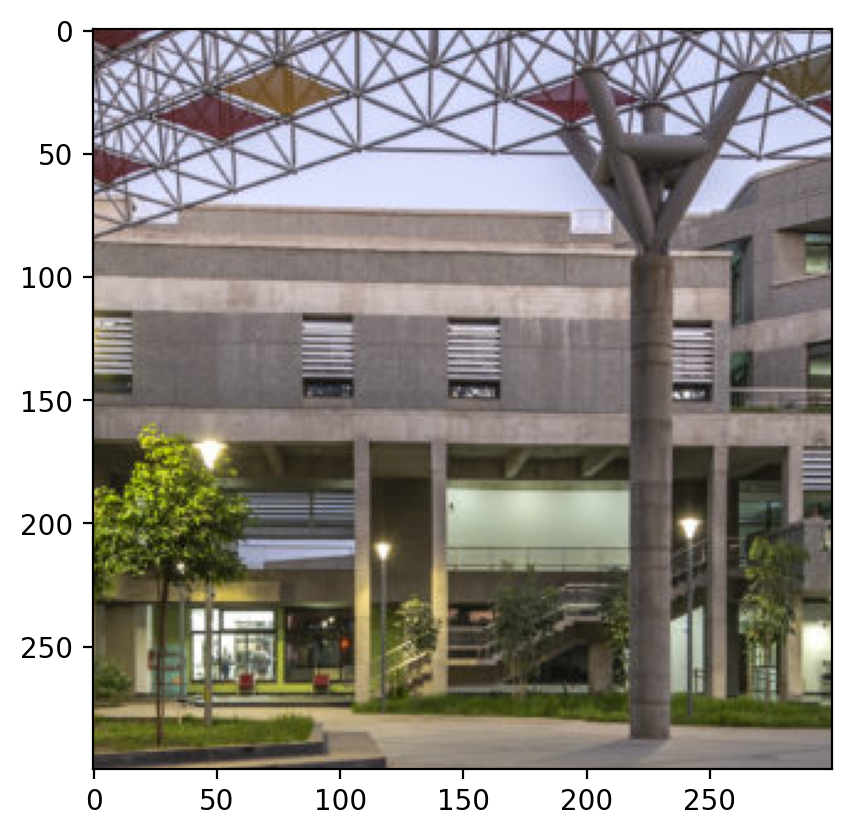

In [10]:
crop = torchvision.transforms.CenterCrop(300)(img_scaled)
print(crop.shape)
plt.imshow(rearrange(crop, 'c h w -> h w c').cpu().numpy())
crop = crop.to(device)

### Masking a square patch on the image

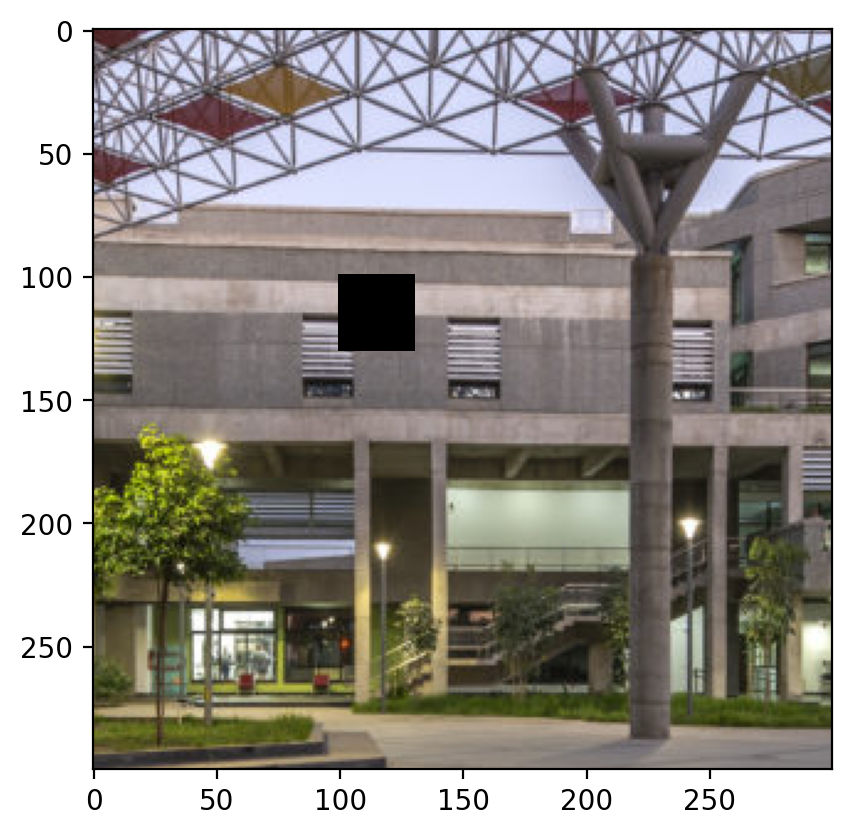

In [11]:
channels, height, width = crop.shape

patch_size = 30

if patch_size > height or patch_size > width:
    raise ValueError("Patch size must be smaller than the dimensions of the image.")

margin = 30  # margin to avoid the corners
# top_left_x = np.random.randint(margin, height - patch_size - margin)
# top_left_y = np.random.randint(margin, width - patch_size - margin)
top_left_x = 100
top_left_y = 100

# Remove the patch from the image
masked_img = crop.clone()
masked_img[:, top_left_x:top_left_x + patch_size, top_left_y:top_left_y + patch_size] = float('nan')

plt.imshow(rearrange(masked_img, 'c h w -> h w c').cpu().numpy())


## Reconstructing using Matrix Factorization

In [12]:
def matrix_factorization(image_tensor, rank, learning_rate=0.01, num_epochs=5000, tol=1e-6, device=torch.device("cpu")):
    """
    Perform matrix factorization using Alternating Least Squares (ALS) algorithm.
    
    Args:
        image_tensor (torch.Tensor): The image tensor to be factorized.
        rank (int): The rank of the factorization.
        learning_rate (float): The learning rate for optimization.
        num_epochs (int): The number of epochs to train the model.
        tol (float): The tolerance for convergence.
        device (torch.device): The device to run the optimization.
    
    Returns:
        W (torch.Tensor): The basis matrix.
        H (torch.Tensor): The coefficient matrix.
        loss (torch.Tensor): The final loss.
        loss_list (list): The list of losses at each epoch.
    """
    image_tensor = image_tensor.to(device)
    channels, height, width = image_tensor.shape
    W = torch.randn(channels, height, rank, requires_grad=True, device=device)
    H = torch.randn(channels, rank, width, requires_grad=True, device=device)
    optimizer = optim.Adam([W, H], lr=learning_rate)
    mask = ~torch.isnan(image_tensor)
    loss_list = []
    prev_loss = float('inf')
    for i in range(1, num_epochs + 1):
        diff_matrix = torch.einsum('chr,crw->chw', W, H) - image_tensor
        diff_vector = diff_matrix[mask]
        loss = torch.norm(diff_vector)
        loss_list.append(loss.item())
        if i % 1000 == 0:
            print(f"Iteration {i}, loss: {loss.item()}")

        if abs(prev_loss - loss.item()) < tol:
            print(f"Converged at iteration {i}, loss: {loss.item()}")
            break
        prev_loss = loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return W, H, loss_list

def plot_result(original_img, masked_img, reconstructed_img, rank, mask_value):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f"Image Reconstruction with Rank={rank} and Mask={mask_value}x{mask_value} patch")
    # Original image
    axes[0].imshow(rearrange(original_img, 'c h w -> h w c').cpu().numpy())
    axes[0].set_title("Original Image")
    axes[0].axis('off')
    # Masked image
    axes[1].imshow(rearrange(masked_img, 'c h w -> h w c').cpu().numpy())
    axes[1].set_title("Masked Image")
    axes[1].axis('off')
    # Reconstructed image
    axes[2].imshow(rearrange(reconstructed_img, 'c h w -> h w c').cpu().detach().numpy())
    axes[2].set_title("Reconstructed Image")
    axes[2].axis('off')
    plt.show()


def calculate_rmse_psnr(original_img, reconstructed_img):
    """
    Calculate the Root Mean Squared Error (RMSE) and Peak Signal-to-Noise Ratio (PSNR) between the original and reconstructed images.
    
    Args:
        original_img (torch.Tensor): The original image tensor.
        reconstructed_img (torch.Tensor): The reconstructed image tensor.
    
    Returns:
        rmse (float): The Root Mean Squared Error (RMSE).
        psnr (float): The Peak Signal-to-Noise Ratio (PSNR).
    """
    if original_img.device != reconstructed_img.device:
        original_img = original_img.to(reconstructed_img.device)
    
    mse = F.mse_loss(reconstructed_img, original_img)
    rmse = torch.sqrt(mse)
    max_pixel_value = 1.0
    psnr = 20 * torch.log10(max_pixel_value / rmse)
    print(f"RMSE: {rmse.item()}")
    print(f"PSNR: {psnr.item()}")
    return rmse.item(), psnr.item()


In [14]:
def image_reconstruction_matrix(img, masked_img, rank, learning_rate=0.01, num_epochs=10000, tol=1e-6, plot=False, keep_original=True, device=torch.device("cpu")):
    """
    Reconstruct the image by filling in the missing patch using matrix factorization.
    
    Args:
        img (torch.Tensor): The original image tensor.
        masked_img (torch.Tensor): The masked image tensor.
        rank (int): The rank of the factorization.
        learning_rate (float): The learning rate for optimization.
        num_epochs (int): The number of epochs to train the model.
        tol (float): The tolerance for convergence.
        plot (bool): Whether to plot the results.
        keep_original (bool): Whether to replace the earlier non-masked pixels in the reconstructed image.
        device (torch.device): The device to run the optimization.
    
    Returns:
        reconstructed_img (torch.Tensor): The reconstructed image tensor.
        loss_list (list): The list of losses at each epoch.
        rmse (float): The Root Mean Squared Error.
        psnr (float): The Peak Signal-to-Noise Ratio.
    """

    img = img.to(torch.float32)
    masked_img = masked_img.to(torch.float32)
    W, H, loss_list = matrix_factorization(masked_img, rank, learning_rate, num_epochs, tol, device)
    reconstructed_img = torch.einsum('chr,crw->chw', W, H)
    # clamp between 0 and 1
    reconstructed_img = torch.clamp(reconstructed_img, 0, 1)
    
    if keep_original:
        # Replace the earlier non-masked pixels in the reconstructed image
        mask = ~torch.isnan(masked_img)
        reconstructed_img[mask] = img[mask]
    
    rmse, psnr = calculate_rmse_psnr(img, reconstructed_img)
    
    if plot:
        plot_result(img, masked_img, reconstructed_img, rank, patch_size)
    
    return reconstructed_img, loss_list, rmse, psnr

Iteration 1000, loss: 34.498878479003906
Iteration 2000, loss: 27.611167907714844
Iteration 3000, loss: 24.382835388183594
Iteration 4000, loss: 22.48456382751465
Iteration 5000, loss: 21.372554779052734
Iteration 6000, loss: 20.683135986328125
Converged at iteration 6259, loss: 20.520366668701172
RMSE: 0.00782653596252203
PSNR: 42.12860870361328


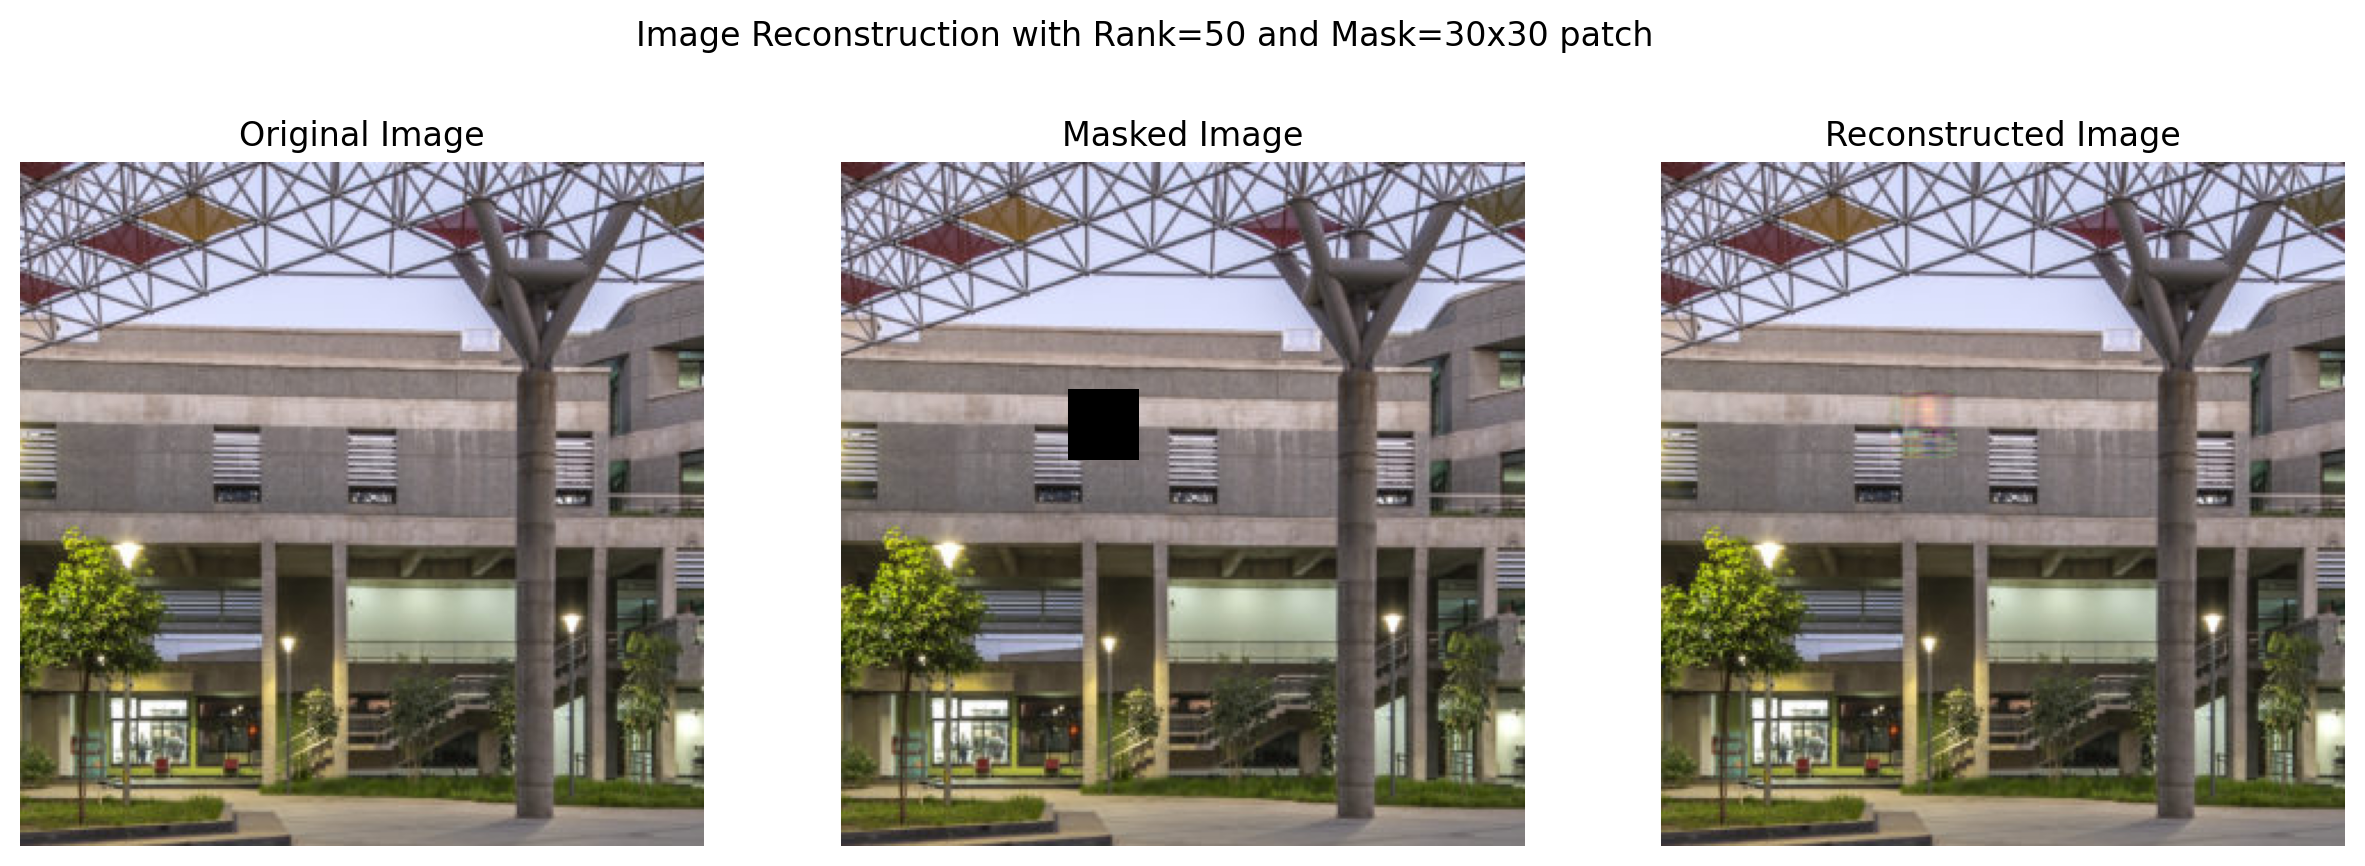

In [15]:
reconstructed_img, loss_list, rmse, psnr = image_reconstruction_matrix(crop, masked_img, rank=50, learning_rate=0.01, num_epochs=10000, tol=1e-6, plot=True, keep_original=True, device=device)

Text(0.5, 1.0, 'Loss vs. Epoch')

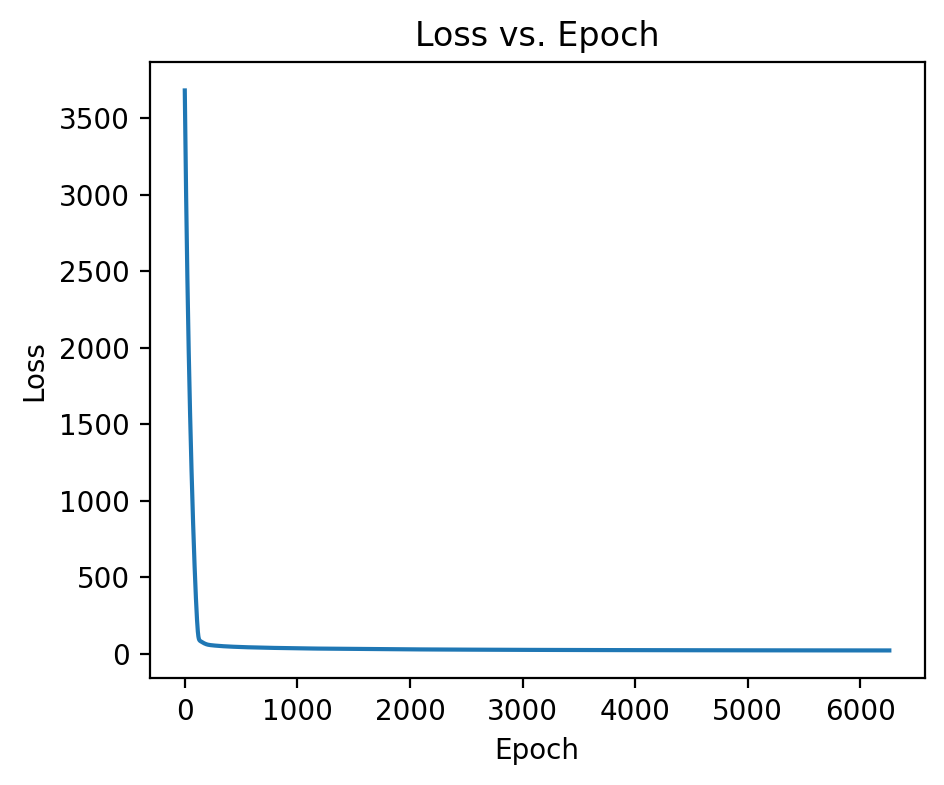

In [16]:
plt.figure(figsize=(5, 4))
plt.plot(loss_list)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs. Epoch")

### Evaluating Matrix Factorization Performance Across Different Ranks

In [17]:
ranks = [5, 10, 20, 50, 100, 200, 400]
results_patch = {}
reconstructed_images_patch = {}

for rank in ranks:
    print("-"*50)
    print(f"Evaluating rank: {rank}")
    print("-"*50)
    reconstructed_img, loss_list, rmse, psnr = image_reconstruction_matrix(
        crop, masked_img, rank, learning_rate=0.01, num_epochs=10000, device=device
    )
    results_patch[rank] = {'Loss': loss_list[-1], 'RMSE': rmse, 'PSNR': psnr}
    reconstructed_images_patch[rank] = reconstructed_img
    print("\n\n")

--------------------------------------------------
Evaluating rank: 5
--------------------------------------------------
Iteration 1000, loss: 69.4603271484375
Iteration 2000, loss: 62.70609664916992
Converged at iteration 2789, loss: 62.40578079223633
RMSE: 0.010972828604280949
PSNR: 39.193626403808594



--------------------------------------------------
Evaluating rank: 10
--------------------------------------------------
Iteration 1000, loss: 59.2303352355957
Iteration 2000, loss: 52.16309356689453
Converged at iteration 2869, loss: 49.941768646240234
RMSE: 0.009480888955295086
PSNR: 40.46302032470703



--------------------------------------------------
Evaluating rank: 20
--------------------------------------------------
Iteration 1000, loss: 49.18218994140625
Iteration 2000, loss: 41.40299606323242
Iteration 3000, loss: 38.3460693359375
Iteration 4000, loss: 37.386051177978516
Converged at iteration 4731, loss: 37.20895004272461
RMSE: 0.00885175820440054
PSNR: 41.0594100952148

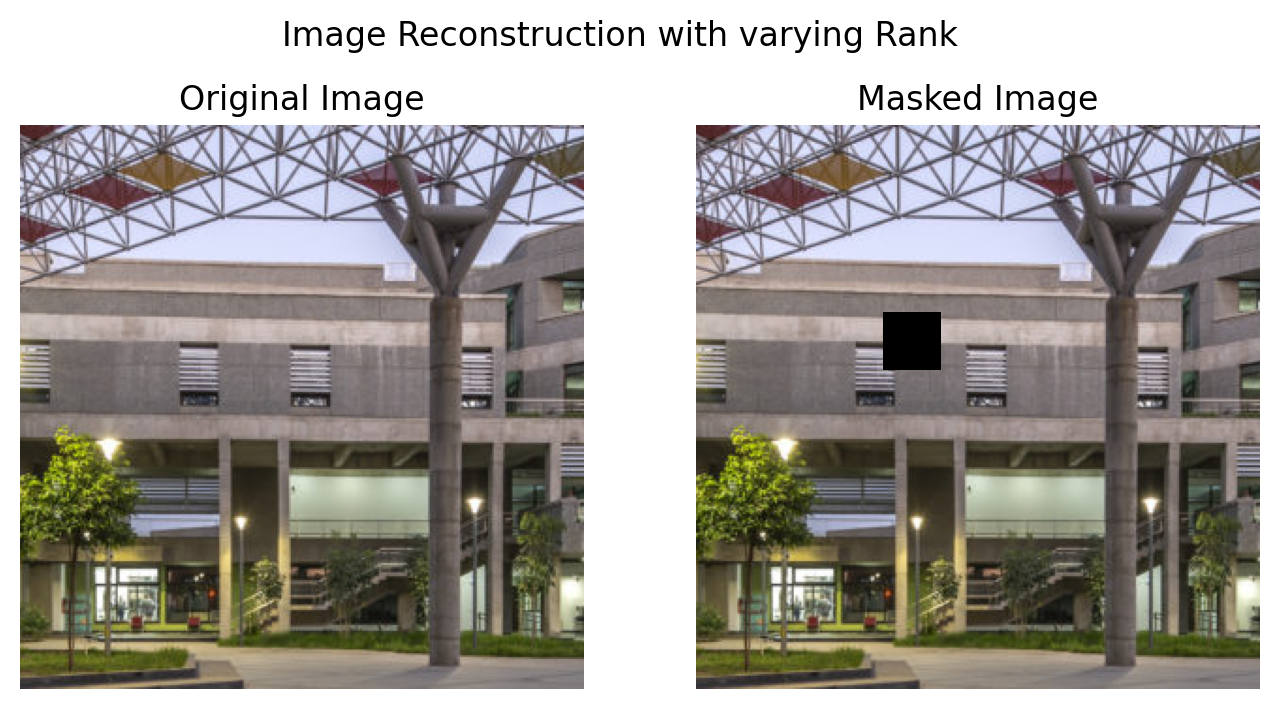

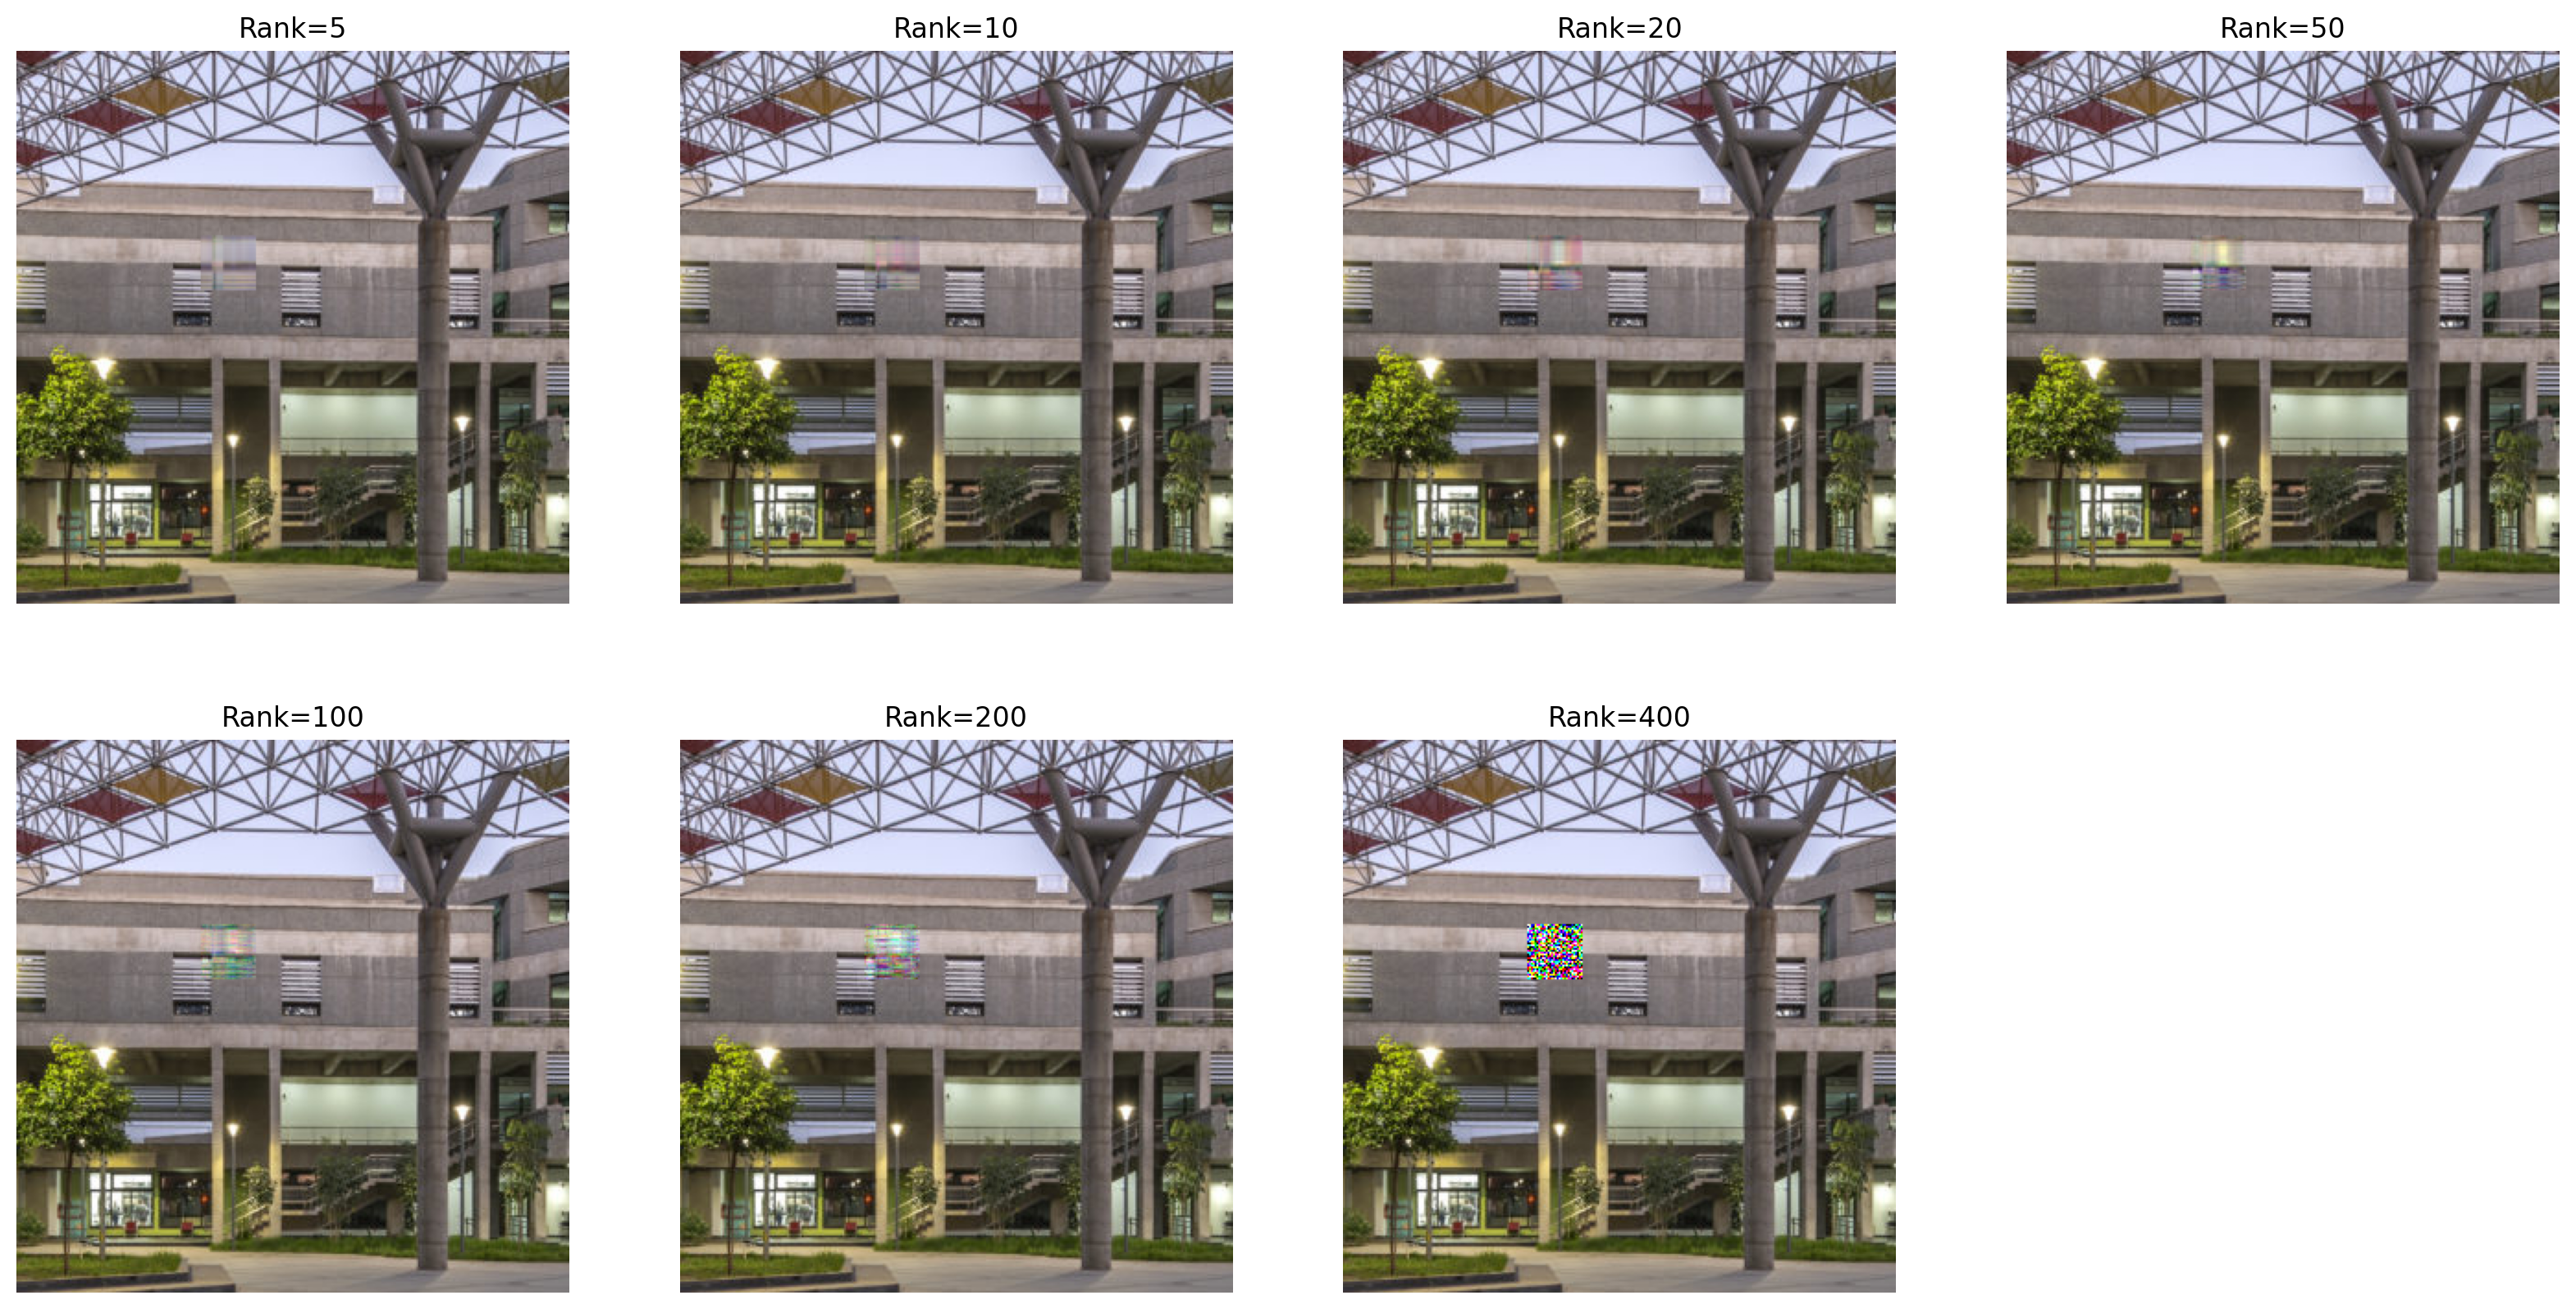

In [18]:
# Show original image, masked image once, and then reconstructed image for each rank
plt.figure(figsize=(8, 4))
plt.suptitle("Image Reconstruction with varying Rank")

# Plot original image
plt.subplot(1, 2, 1)
plt.imshow(rearrange(crop, 'c h w -> h w c').cpu().numpy())
plt.title("Original Image")
plt.axis('off')

# Plot masked image
plt.subplot(1, 2, 2)
plt.imshow(rearrange(masked_img, 'c h w -> h w c').cpu().numpy())
plt.title("Masked Image")
plt.axis('off')

plt.figure(figsize=(20, 10))
# Plot reconstructed images for each rank
for i, rank in enumerate(ranks):
    plt.subplot(2, len(ranks)//2+1, i+1)
    plt.imshow(rearrange(reconstructed_images_patch[rank], 'c h w -> h w c').cpu().detach().numpy())
    plt.title(f"Rank={rank}")
    plt.axis('off')

plt.show()

Rank: 5, Loss: 62.40578079223633, RMSE: 0.010972828604280949, PSNR: 39.193626403808594
Rank: 10, Loss: 49.941768646240234, RMSE: 0.009480888955295086, PSNR: 40.46302032470703
Rank: 20, Loss: 37.20895004272461, RMSE: 0.00885175820440054, PSNR: 41.059410095214844
Rank: 50, Loss: 19.7823429107666, RMSE: 0.007909209467470646, PSNR: 42.03733825683594
Rank: 100, Loss: 16.676855087280273, RMSE: 0.00978082139045, PSNR: 40.1924934387207
Rank: 200, Loss: 10.619811058044434, RMSE: 0.0125101488083601, PSNR: 38.054752349853516
Rank: 400, Loss: 12.013533592224121, RMSE: 0.05032223463058472, PSNR: 25.96480369567871


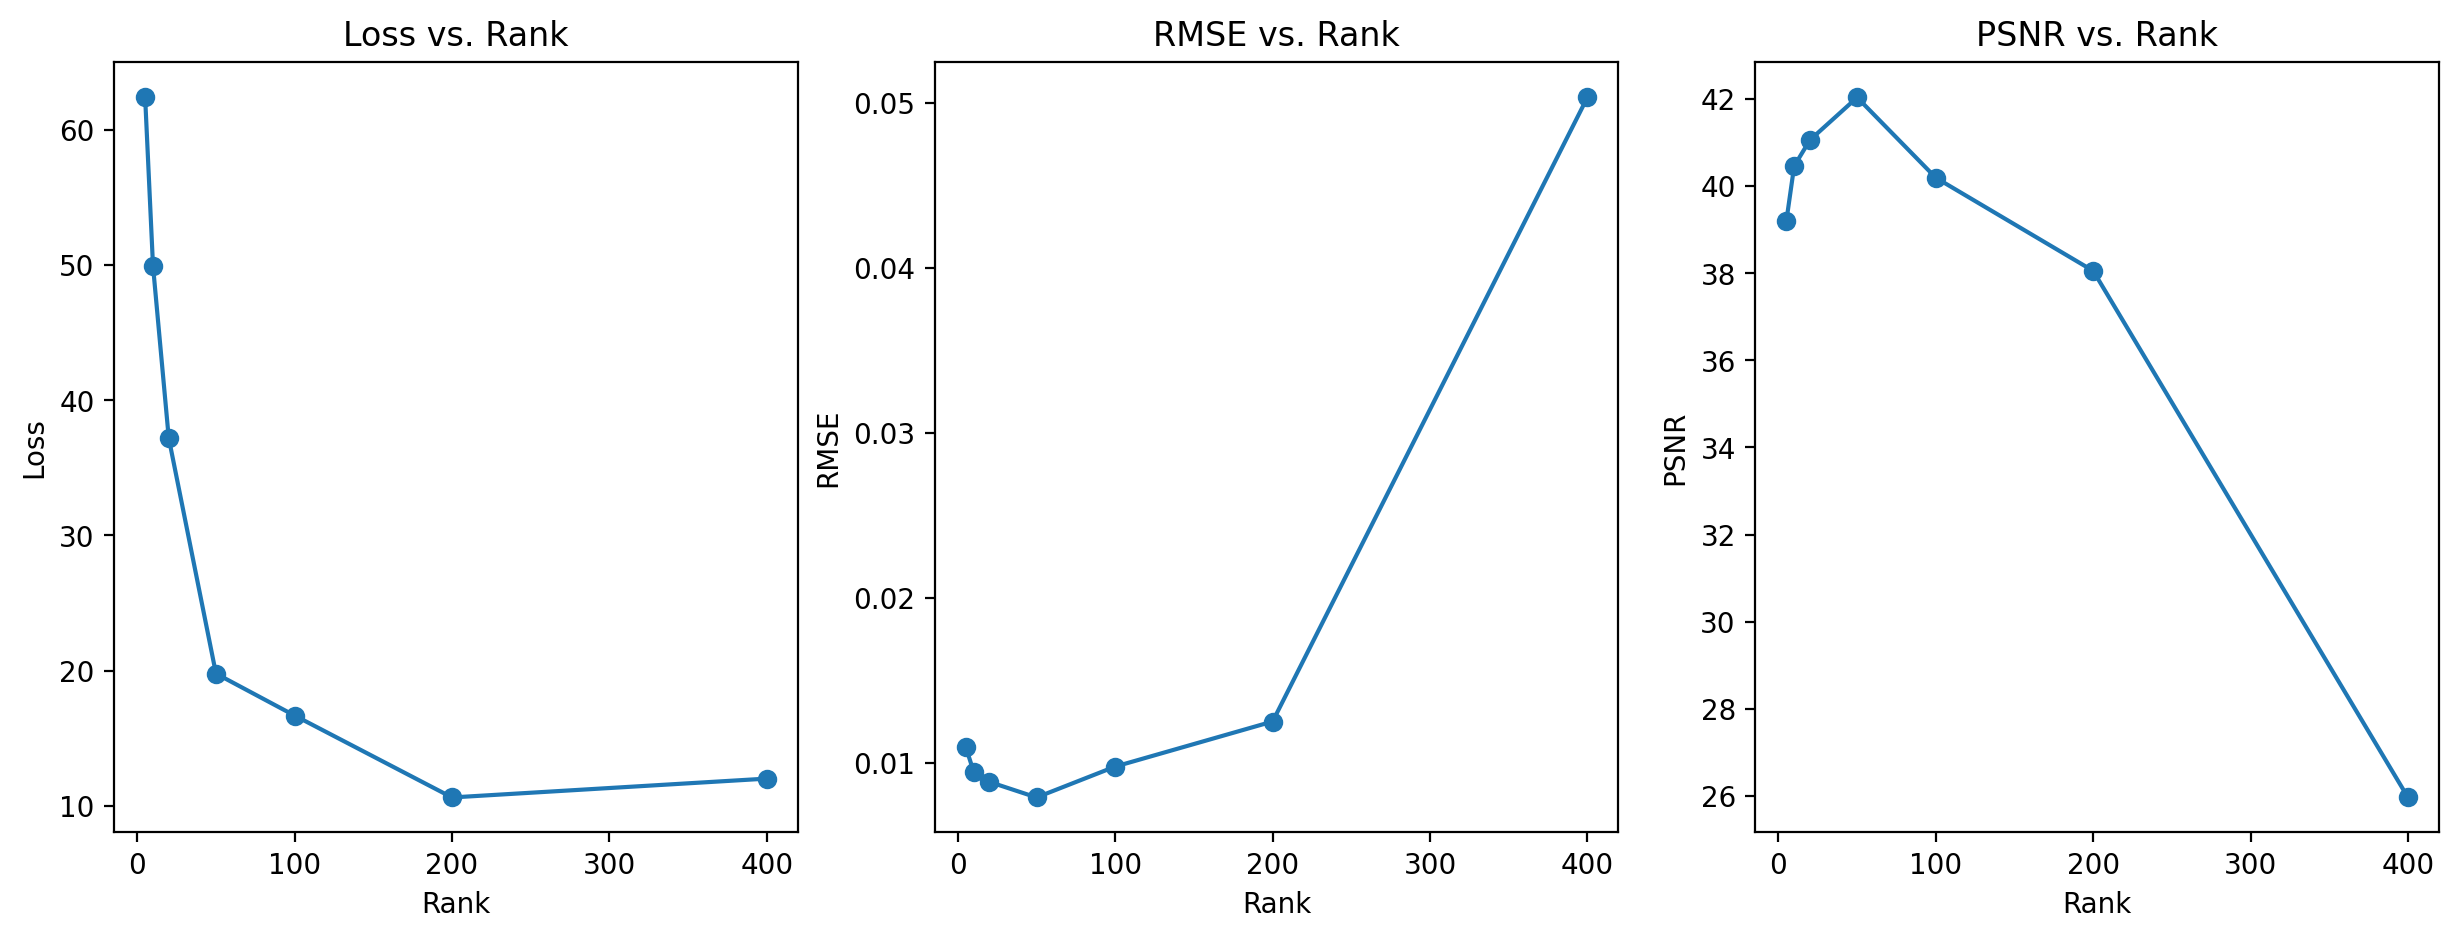

In [19]:
# Print the results for each rank
for rank, metrics in results_patch.items():
    print(f"Rank: {rank}, Loss: {metrics['Loss']}, RMSE: {metrics['RMSE']}, PSNR: {metrics['PSNR']}")
    
ranks_list = list(results_patch.keys())
loss_list = [metrics['Loss'] for metrics in results_patch.values()]
rmse_list = [metrics['RMSE'] for metrics in results_patch.values()]
psnr_list = [metrics['PSNR'] for metrics in results_patch.values()]

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(ranks_list, loss_list, marker='o')
plt.xlabel('Rank')
plt.ylabel('Loss')
plt.title('Loss vs. Rank')
plt.subplot(1, 3, 2)
plt.plot(ranks_list, rmse_list, marker='o')
plt.xlabel('Rank')
plt.ylabel('RMSE')
plt.title('RMSE vs. Rank')
plt.subplot(1, 3, 3)
plt.plot(ranks_list, psnr_list, marker='o')
plt.xlabel('Rank')
plt.ylabel('PSNR')
plt.title('PSNR vs. Rank')
plt.show()